# Noise Creation Walkthrough

_Notebook was created by:_ Max Schmitz
_on:_ 11/03/2022

The data used in this research so far was simulated for optimal conditions, and no noise or other perturbations have been taken into account. To incorporate noise, zero-mean independent, identically distributed with variance sigma squared Gaussian noise has been added on top of the displacement data. Since only the 2D-FFT data for each simulation was saved, a transformation from the frequency-wavenumber into the displacement-time space is needed first.

This file inverts data and then adds the noise on a couple of sample files to show the procedure. The used functions and procedure need to be still run on all files given.

This notebook will
1. load a 2D-FFT file with respective frequency and wavenumber grid
2. apply the inverse 2D-FFT to obtain the data in the _time $\times$ displacement_ domain (hopefully that is giving some meaningful results because I deleted the phase information and only the amplitude information is included now!!!)
3. add noise to the measurement in the time-displacement domain (figure out which noise and to which magnitude)
4. transform the data with noise from the time-displacement domain now back to the frequency-wavenumber domain with the 2D-FFT again
5. apply non-maximum-suppression to the noisy data and display feature extraction process
6. save data to for non-maximum-suppression


In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

In [18]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from utils import load_2dfft_processed_data, store_fft_data, non_maximum_suppression, extract_features, lin_func
from postprocess_2dfft_max_v15 import invert_2dfft, reapply_2dfft, add_noise # TODO: move this function to the utils file

In [13]:
def plot_contourf_fk(f_grid, k_grid, fft_data, title: str = 'put title here'):
    fig = plt.figure(1, dpi=300)
    ax = fig.gca()
    ax.contourf(f_grid, k_grid, fft_data, 300, cmap='Spectral', zorder=-40)
    plt.axis([0, 8000, 0, 2.5E7])
    plt.title(title)
    plt.xlabel('Wavenumber in 1/m')
    plt.ylabel('Frequency in Hz')
    return ax

In [4]:
from IPython.display import Audio, display

def all_done():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

## 1. Load 2D-FFT file

In [5]:
# -- Specify folder to work in/where data lays
data_path = pathlib.Path().resolve() / '2dfft_data_selected' / '200._1._2._1._70'

# -- Specify file names for example file
fn = '11-09_19-25-13_max_analysis_job_disp_2dfft_fg_0.0002.csv'

fg, kg, abs_fft_data, sim_info = load_2dfft_processed_data(fn, data_path)
print('>> frequency-/wavenumber grid, 2D-FFT data, and simulation information file was loaded!')

>> frequency-/wavenumber grid, 2D-FFT data, and simulation information file was loaded!


Visualize the original 2D-FFT data

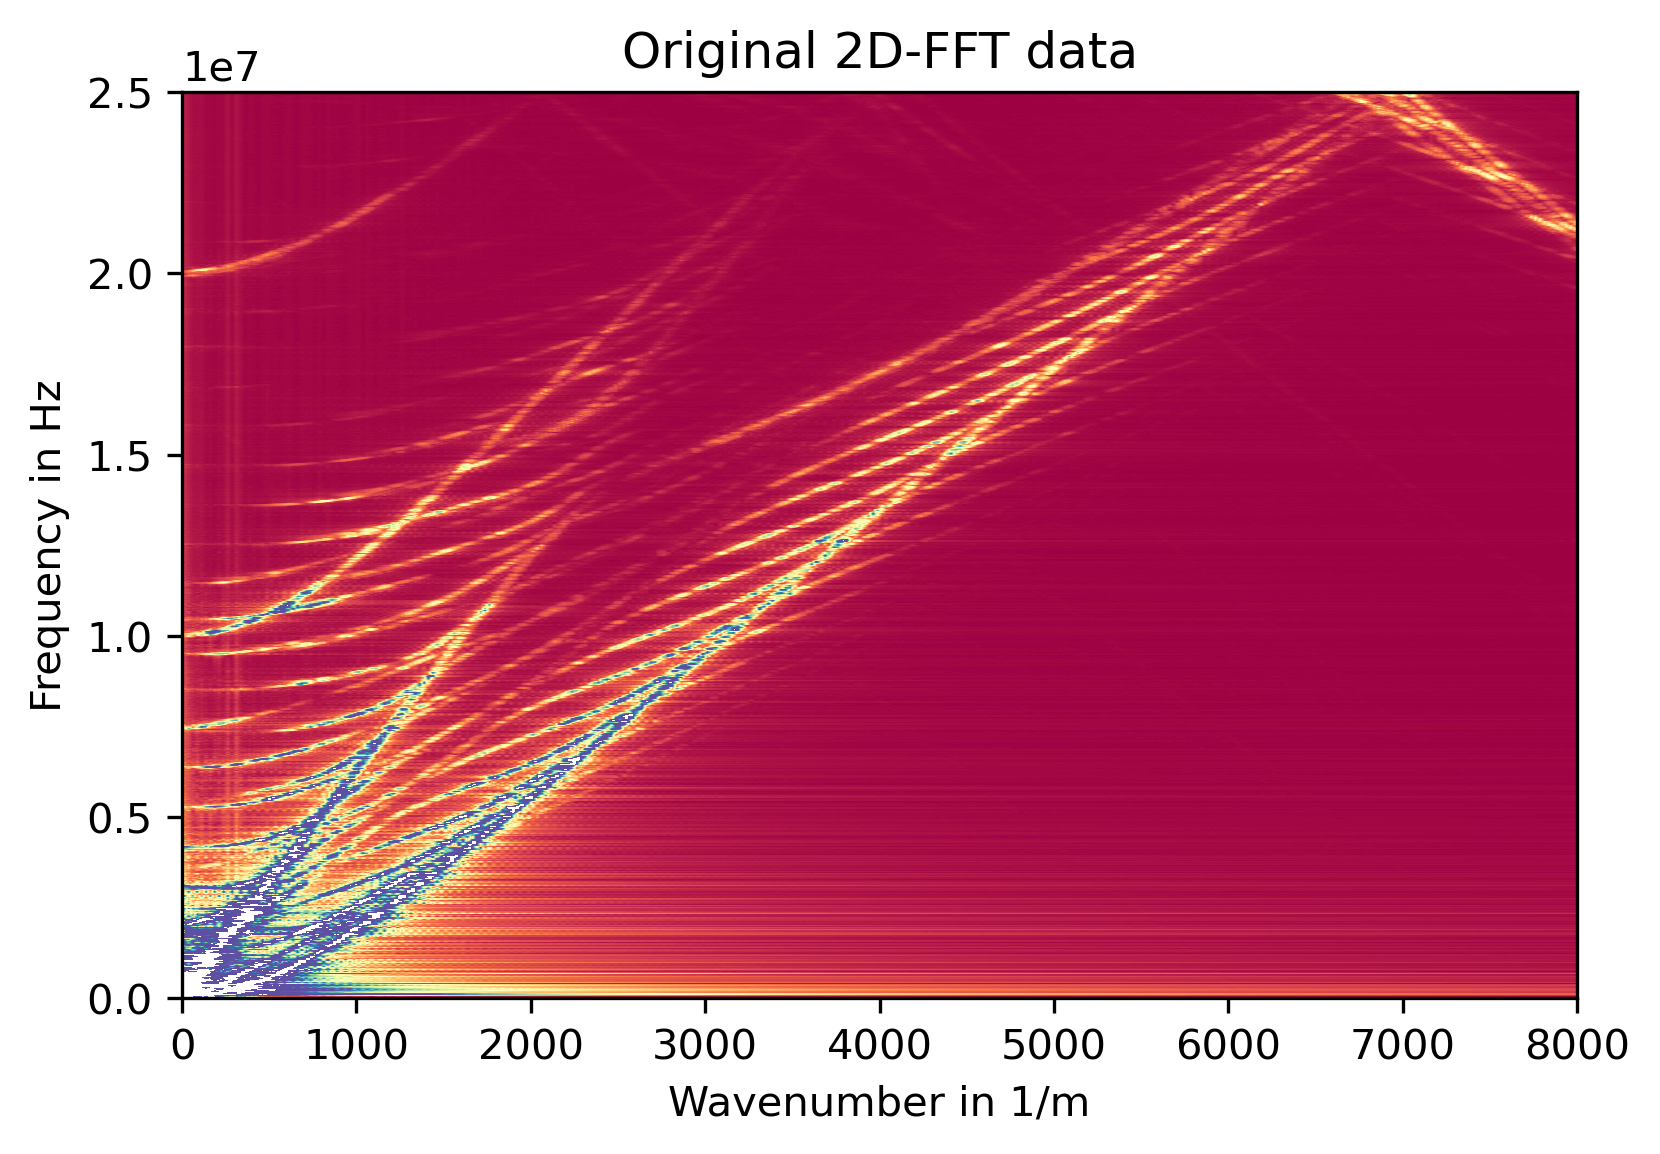

In [40]:
plot_contourf_fk(fg, kg, abs_fft_data, 'Original 2D-FFT data')

## 2. Apply inverse 2D-FFT

In [6]:
displacement_x_time, dt, dx, Nt, Nx = invert_2dfft(fg, kg, abs_fft_data, sim_info)
print('>> 2D-FFT data has been inverted to displacement-time data!')

>> 2D-FFT data has been inverted to displacement-time data!


## 3. Add noise to sampling

In [31]:
signal_to_noise_ratio_db = 40
displacement_x_time_n = add_noise(displacement_x_time, snr_db=signal_to_noise_ratio_db)
print(f'>> noise with SNR = {signal_to_noise_ratio_db} was added to displacement data!')

>> noise with SNR = 40 was added to displacement data!


## 4. Transform data back into frequency-wavenumber domain with 2D-FFT

In [32]:
fg_n, kg_n, abs_fft_data_n = reapply_2dfft(displacement_x_time_n, dt, dx, Nt, Nx)
print('>> noisy displacement data was transformed back to frequency-wavenumber domain!')

--- np 2dfft time: 0.7689976692199707 seconds ---
>> noisy displacement data was transformed back to frequency-wavenumber domain!


## 5. Apply Non-Maximum-Suppression to noisy data

In [22]:
# convert pixel into frequency and wavenumber
def p_2_k(p, kg):
    """ Convert pixel to wavenumber"""
    return kg[p, 0]

def k_2_p(k, kg):
    """ Convert wavenumber to pixel """
    e = np.absolute(k - kg[0, :])
    return e.argmin()

def p_2_f(p, fg):
    """ Convert pixel to frequency """
    return fg[0, p]

def f_2_p(f, fg):
    """ Convert frequency to pixel """
    e = np.absolute(f - fg[0, :])
    return e.argmin()



torch.Size([1, 1, 2300, 1718])
fft_p.shape = (2300, 1718)
len(b[0]) = 16255
b = (array([   0,   10,   10, ..., 2299, 2299, 2299], dtype=int64), array([   1,    1,    9, ..., 1426, 1503, 1656], dtype=int64))
number of maxima detected: 687


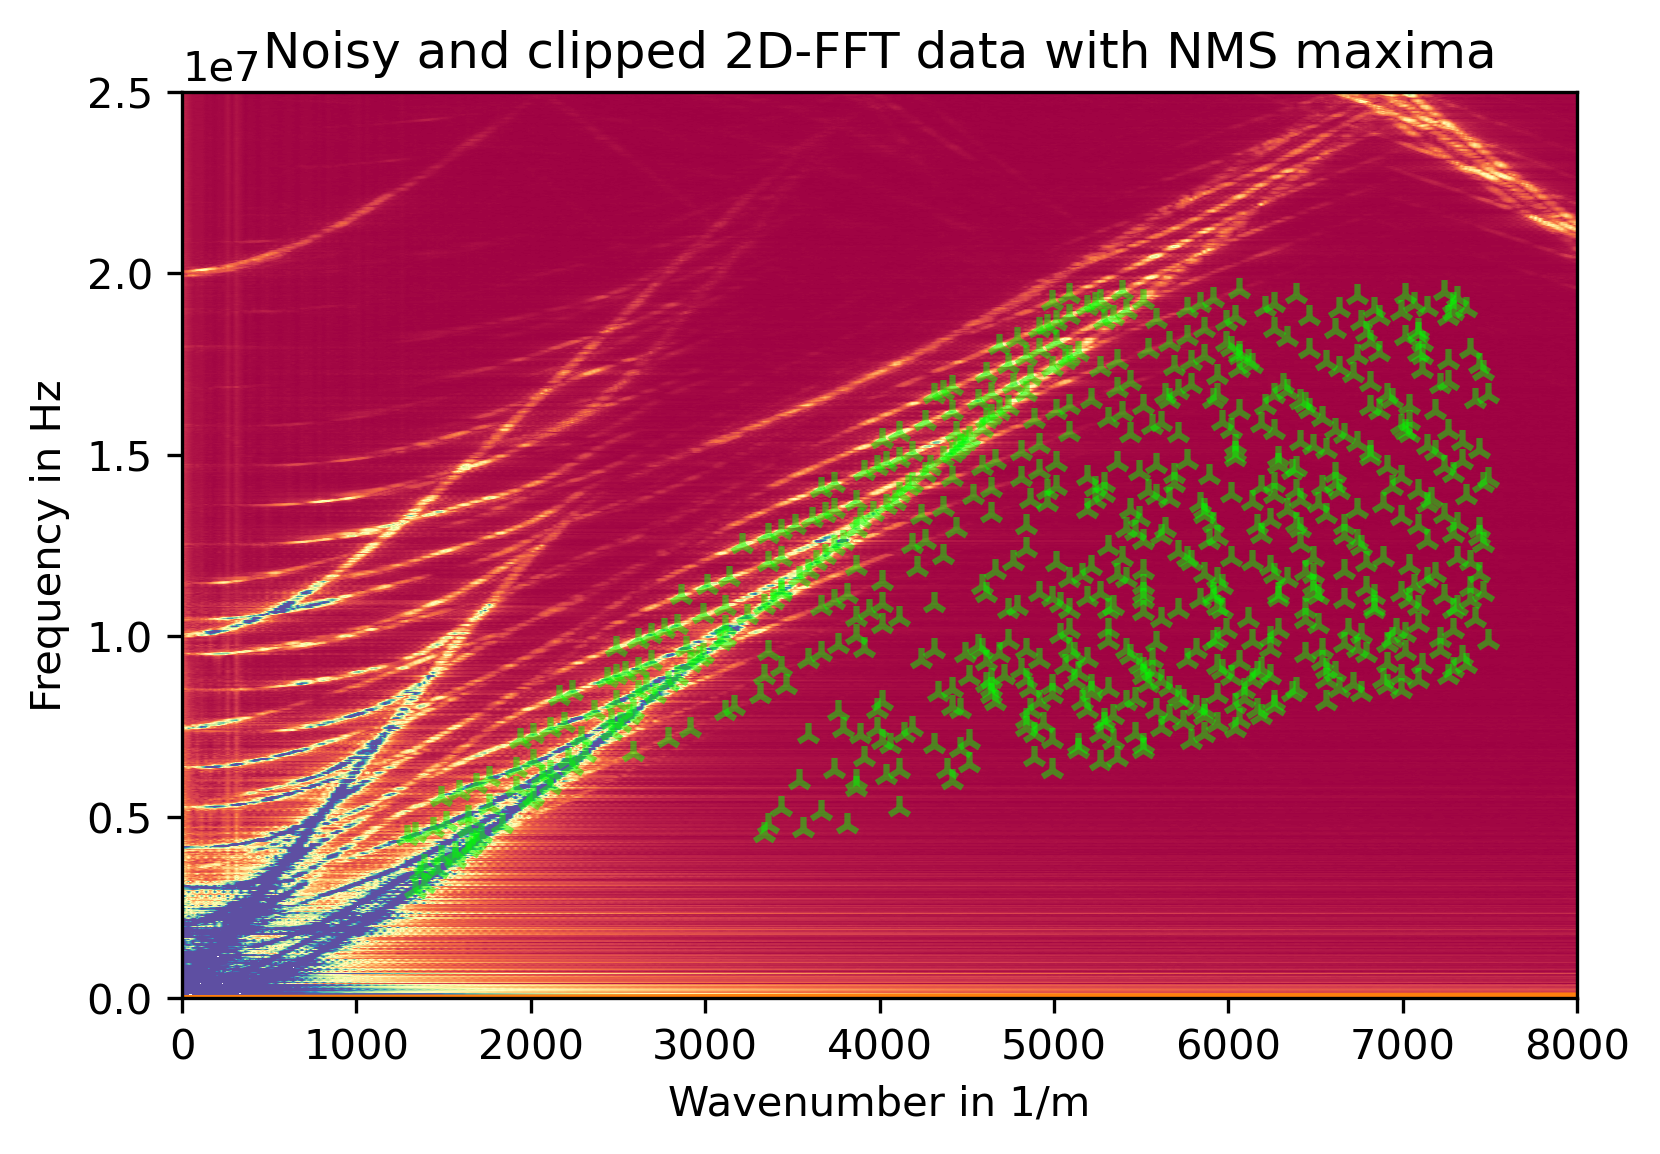

In [33]:
abs_fft_data_n_c, x, y = non_maximum_suppression(
    abs_fft_data_n,
    f"{fn[0:37]}_{signal_to_noise_ratio_db}",
    data_path,
    clip_tr=0.0001,  # 1, 0.0002, 0.0001,
    kernel=15, #15,
    gradient = [2.8, 9],
    save_flag=False,
    plot_flag=False
)

ax_xy = plot_contourf_fk(fg, kg, abs_fft_data_n_c, 'Noisy and clipped 2D-FFT data with NMS maxima')
ax_xy.scatter(fg[0, x], kg[y, 0], color='lime',
                   marker='2', alpha=0.5, label='NMS maxima', zorder=2)  # alpha was 0.7

# display nms-cone
xl_plot = np.linspace(0, p_2_k(700, kg))
xu_plot = np.linspace(0, p_2_k(700, kg))
ax_xy.plot(xl_plot, 2.8 * xl_plot)
ax_xy.plot(xu_plot, 9 * xu_plot)

# display fitted function
coeffs = extract_features(lin_func, x, y, fg, kg)
x_plot = np.linspace(0, 7000)
ax_xy.plot(x_plot, lin_func(x_plot, *coeffs), color='b')

plt.show()

all_done()

## 6. Store noisy 2D-FFT data

In [ ]:
store_fft_data(
    fn,
    data_path,
    abs_fft_data_n,
    fg_n,
    kg_n,
    sim_info
)

## Visualize the outputs

Visualize only the noisy 2D-FFT data

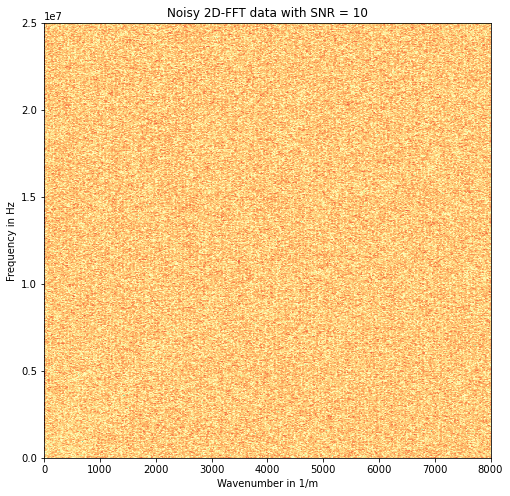

In [33]:
fig = plt.figure(figsize=(8, 8))
plot_contourf_fk(fg, kg, abs_fft_data_n, f'Noisy 2D-FFT data with SNR = {signal_to_noise_ratio_db}')
plt.savefig(f"2dfft_data_selected/Noisy_2DFFT_SNR_{signal_to_noise_ratio_db}.png", dpi=600)
all_done()

Visualize transformed 2D-FFT data together with original data

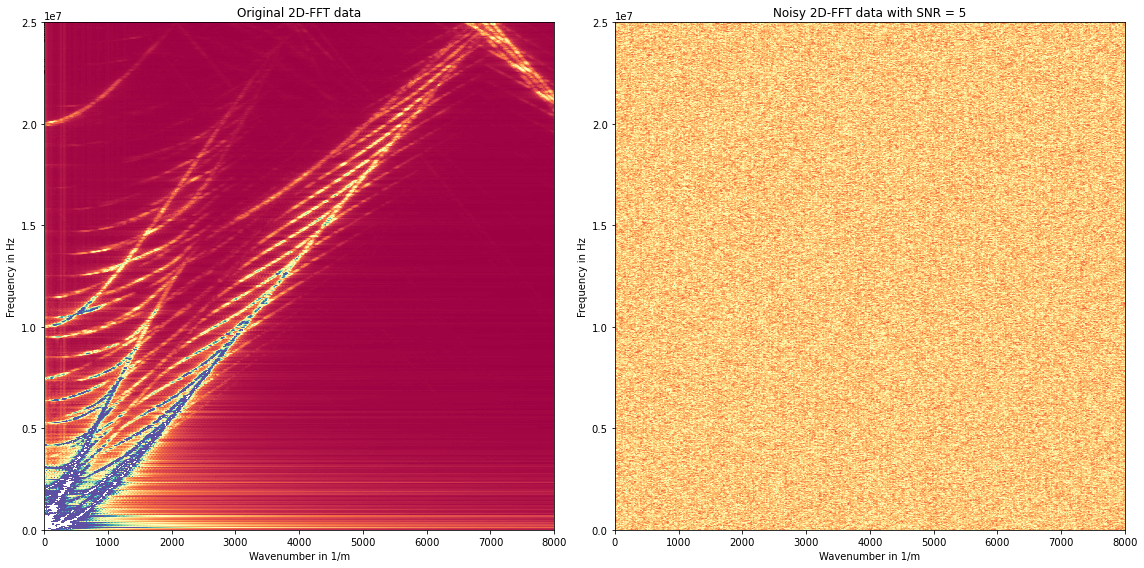

In [24]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_contourf_fk(fg, kg, abs_fft_data, 'Original 2D-FFT data')
plt.subplot(1, 2, 2)
plot_contourf_fk(fg, kg, abs_fft_data_n, f'Noisy 2D-FFT data with SNR = {signal_to_noise_ratio_db}')
plt.tight_layout()